# Hands-on Lithium Ion Battery (LIB) modelling

Installing libraries

In [2]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pybamm==21.12

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Model set up

In [2]:
# set the model type
model = pybamm.lithium_ion.NewmanTobias()

# set the default model geometry
geometry = model.default_geometry

Uncomment the following plot to show all the model paramenters

In [3]:
# format_str = '{:<75}  {:>20}'
# print(format_str.format('PARAMETER', 'VALUE'))
# print("-"*97)
# for key, value in model.default_parameter_values.items():
#     try:
#         print(format_str.format(key, value))
#     except TypeError:
#         print(format_str.format(key, value.__str__()))

Let's chage the nominal capacity

In [4]:
# set the default model parameters
param = model.default_parameter_values
# NOMINAL_Q = 2.0 # [Ah]
# param['Nominal cell capacity [A.h]'] = NOMINAL_Q  
# param['Cell volume [m3]'] = 7.8e-06*2
param["Current function [A]"] = "[input]" # [A] will be a model input

# set the parameters for the model and the geometry
param.process_model(model)
param.process_geometry(geometry)

# mesh the domains
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise the model equations
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

In [5]:
NOMINAL_Q = param['Nominal cell capacity [A.h]'] 

Now lets discharge the battery per 1h



In [6]:
# Lets use the default solver to compute the discharge curve
solver = model.default_solver
n = 361 # how many point to evaluate
t_eval = np.linspace(0, 3600, n) # [s]
solution = solver.solve(model, t_eval, inputs={'Current function [A]': NOMINAL_Q /1})

lets plot the result

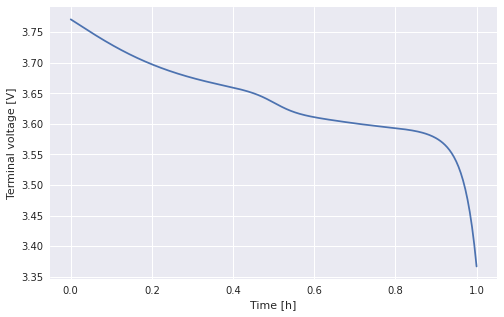

In [7]:
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries

fig = plt.figure(figsize=(8,5))

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time, voltage)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")

plt.show()

## Find the 1 C-rate current

We are going to use a old but simple method but effective metod to find the exact value of current to discharge the battery afte 1 hour with a cut of current of 3.3 V.
We are going to use [Secant Method](https://en.wikipedia.org/wiki/Secant_method) to find the zero of the follinwing target function:

$ f(i) = V_{end}(i) - V_{cut-off} $ 

> Note: a battery is discharge when the terminal voltage cross the cut-off value

In [8]:
# from scipy.optimize import differential_evolution # genetic algorithm optimizer

# CUTOFF_V = 3.3 
# i_min = NOMINAL_Q * 0.6/ 1.
# i_max = NOMINAL_Q * 1.5 / 1.

# def f_target(i):
#     solution = solver.solve(model, t_eval, inputs={'Current function [A]': i})
#     V_new = solution["Terminal voltage [V]"].entries[-1]
#     return V_new-CUTOFF_V

# differential_evolution(f_target, bounds=[(i_min, i_max)])

In [9]:
from scipy.interpolate import interp1d

CUTOFF_V = 3.5

i_0 = NOMINAL_Q * 0.8/ 1.
i_1 = NOMINAL_Q * 1.1 / 1.

def f_target(t):
    return t-1

def get_cut_off_time(V, t):
    # diff = np.abs(V-CUTOFF_V)
    # indx = np.where(diff == diff.min())[0]
    # return t[indx][0]
    f_int = interp1d(V, t)
    return f_int(CUTOFF_V)

t_eval = np.linspace(0, 7200, 361)
solution_0 = solver.solve(model, t_eval, inputs={'Current function [A]': i_0})
tc_0 = get_cut_off_time(solution_0["Terminal voltage [V]"].entries, 
                        solution_0["Time [h]"].entries ) 
solution_1 = solver.solve(model, t_eval, inputs={'Current function [A]': i_1})
tc_1= get_cut_off_time(solution_1["Terminal voltage [V]"].entries, 
                        solution_1["Time [h]"].entries ) 

# The loop end when diffence between two consecutive aptempt are less that 5% 
n_int = 0
while abs(tc_0-tc_1) > 0.001:
    i_new = i_1 - f_target(tc_1)*(i_1-i_0) / (f_target(tc_1)- f_target(tc_0))
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': i_new})
    tc_new= get_cut_off_time(solution["Terminal voltage [V]"].entries, 
                             solution["Time [h]"].entries )
    print(f"[{n_int+1}]\ti_new: {i_new:1.5g} A\ttc_new: {tc_new:1.5g} h") 
    i_0 = i_1
    i_1 = i_new
    tc_0 = tc_1
    tc_1 = tc_new
    n_int += 1
C_RATE = i_1
print(f"C-rate current = {C_RATE} A")

[1]	i_new: 0.67592 A	tc_new: 0.97654 h
[2]	i_new: 0.65838 A	tc_new: 1.0032 h
[3]	i_new: 0.66047 A	tc_new: 1 h
[4]	i_new: 0.66049 A	tc_new: 1 h
C-rate current = 0.6604925535328426 A


Let's plot the result

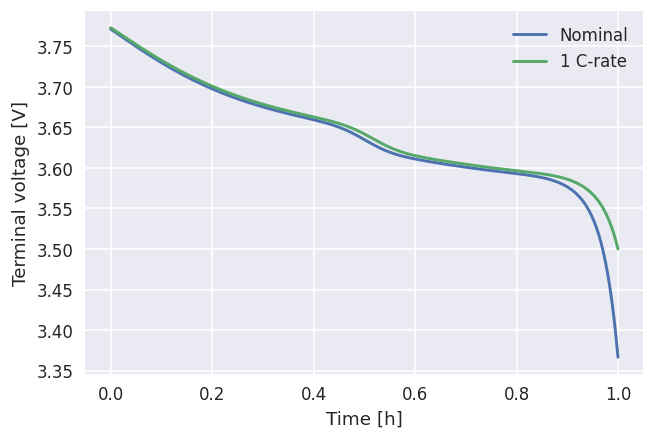

In [10]:
t_eval = np.linspace(0, 3600, 361)
solution_old = solver.solve(model, t_eval, inputs={'Current function [A]': NOMINAL_Q/1.})
solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE})

time_old = solution_old["Time [h]"].entries
voltage_old = solution_old["Terminal voltage [V]"].entries
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries

fig = plt.figure(figsize=(6,4), dpi=120)

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time_old, voltage_old, label='Nominal')
    ax.plot(time, voltage, label='1 C-rate')
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

In [18]:
np.linspace(0, 7200, 181)

array([   0.,   40.,   80.,  120.,  160.,  200.,  240.,  280.,  320.,
        360.,  400.,  440.,  480.,  520.,  560.,  600.,  640.,  680.,
        720.,  760.,  800.,  840.,  880.,  920.,  960., 1000., 1040.,
       1080., 1120., 1160., 1200., 1240., 1280., 1320., 1360., 1400.,
       1440., 1480., 1520., 1560., 1600., 1640., 1680., 1720., 1760.,
       1800., 1840., 1880., 1920., 1960., 2000., 2040., 2080., 2120.,
       2160., 2200., 2240., 2280., 2320., 2360., 2400., 2440., 2480.,
       2520., 2560., 2600., 2640., 2680., 2720., 2760., 2800., 2840.,
       2880., 2920., 2960., 3000., 3040., 3080., 3120., 3160., 3200.,
       3240., 3280., 3320., 3360., 3400., 3440., 3480., 3520., 3560.,
       3600., 3640., 3680., 3720., 3760., 3800., 3840., 3880., 3920.,
       3960., 4000., 4040., 4080., 4120., 4160., 4200., 4240., 4280.,
       4320., 4360., 4400., 4440., 4480., 4520., 4560., 4600., 4640.,
       4680., 4720., 4760., 4800., 4840., 4880., 4920., 4960., 5000.,
       5040., 5080.,

In [10]:
solution_1["Time [h]"].entries

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

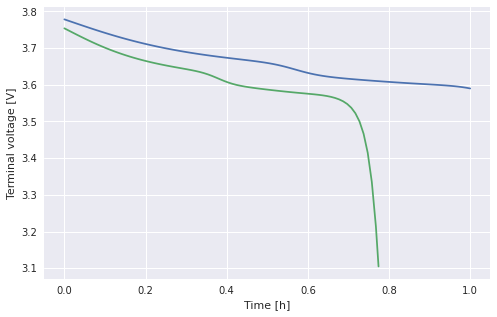

In [8]:
time = solution_0["Time [h]"].entries
voltage = solution_0["Terminal voltage [V]"].entries
time_1 = solution_1["Time [h]"].entries
voltage_1 = solution_1["Terminal voltage [V]"].entries

fig = plt.figure(figsize=(8,5))

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time, voltage)
    ax.plot(time_1, voltage_1)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")

plt.show()

In [53]:
# Solution with current = 0.68
old_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 0.68})
old_time = old_solution["Time [h]"].entries
old_voltage = old_solution["Terminal voltage [V]"].entries

# Solution with current = 1.4
new_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 1.4})
new_time = new_solution["Time [h]"].entries
new_voltage = new_solution["Terminal voltage [V]"].entries

plt.plot(old_time, old_voltage, lw=2, label="Current = 0.68")
plt.plot(new_time, new_voltage, lw=2, label="Current = 1.4")
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

SolverError: ignored

In [ ]:
solution.plot()

In [ ]:
with plt.style.context("seaborn"):
    sim_dfn.plot()

In [6]:
fig.savefig("test.png")